STAT 453: Deep Learning (Spring 2020)    
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/   
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

---

Ritikkumar Goyal
ragoyal2@wisc.edu

In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p matplotlib,torch,pandas,numpy,PIL,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Sebastian Raschka 

CPython 3.7.4
IPython 7.8.0

matplotlib 3.1.1
torch 1.4.0
pandas 0.25.1
numpy 1.17.2
PIL 6.2.0
sklearn 0.21.3


Note that Python's Imaging Library (PIL) can be installed via 

    conda install pillow 

**If you have any installation issues, please don't hesitate to ask via Piazza!**

# HW 3: Graduate Student Descent! Training and Tuning a Multilayer Perceptron (40 pts)

**Your task in this homework is to take this existing Multilayer Perceptron implementation and change it to achieve a better performance on [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist).**

---
<font color='darkred'>
For the successfull outcome of this homework:
    
- Your Validation and Test set accuracies should be

     - greater than 85% for 10 pts
     - greater than 86% for 20 pts
     - greater than 87% for 30 pts
     - greater than 88% for 40 pts    
    

- Answer the questions at the bottom of this notebook
- Submit this Jupyter Notebook with your modifications as .ipynb and .html file to Canvas (similar to previous homeworks)
</font>
---

**And as promised in class, the student with the highest performance will receive a little gift!**

---

Please read and execute this notebook first to make sure everything works correctly. Then, feel free to make any changes to the architecture, i.e., you can change

- the number of layers
- the activation function(s) (logistic sigmoid, tanh, relu, leaky relu, ...)
- the learning rate
- the number of hidden layers
- the number of units in the hidden layer(s)
- the number of epochs
- the minibatch size

However,

- don't change the weight initialization
- don't change the random seed
- don't change the optimization algorithm

The cells where you can/should make changes are clearly highlighted. For instance, I added comments as shown below:

```

```

In [1]:
import torch
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# No need to change anything here!
# If there is a GPU available, it will use it,
# otherwise, it will use the CPU

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Loading the Dataset

The dataset consists of 10 classes similar to the original MNIST dataset. Also, it shares the same overall structure with MNIST, i.e., there are 60k training images and 10k test images, and all images are black & white images of size 28x28. 

Below is an example of how the images look like:

![](figures/fashion-mnist-sprite.png)

(Image Source: https://github.com/zalandoresearch/fashion-mnist)



The 10 classes in this dataset are


| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Before you continue, please execute the companion notebook "Notebook for Preparing the Dataset for HW3" ([`hw3-dataprep.ipynb`](hw3-dataprep.ipynb)) for downloading and preparing the dataset.

---

## Dataset Loader

In [3]:
NUM_CLASSES = 9

In [4]:
def task_importance_weights(label_array):
    uniq = torch.unique(label_array)
    num_examples = label_array.size(0)

    m = torch.zeros(uniq.shape[0])

    for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0), 
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())

    imp = m/torch.max(m)
    return imp

In [5]:
labels = pd.read_csv("train_normalized.csv")["Label"].values
labels = torch.tensor(labels, dtype=torch.int8)

In [6]:
imp = task_importance_weights(labels)
imp = imp[0:NUM_CLASSES-1]
imp = imp.to(DEVICE)

In [7]:
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

import os


# class FashionMNISTDataset(Dataset):
#     """Custom Dataset for loading FashionMNIST images"""

#     def __init__(self, csv_path, img_dir, transform=None):
    
#         df = pd.read_csv(csv_path)
#         self.img_dir = img_dir
#         self.img_names = df['image_name'].values
#         self.y = df['class_label'].values
#         self.transform = transform

#     def __getitem__(self, index):
#         img = Image.open(os.path.join(self.img_dir,
#                                       self.img_names[index]))
        
#         if self.transform is not None:
#             img = self.transform(img)
        
#         label = self.y[index]
#         return img, label

#     def __len__(self):
#         return self.y.shape[0]

class StockDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.y = df['Label'].to_numpy().astype(int)
        self.features = df.drop(["Company", "Date", "Target", "Label"], axis=1).to_numpy().astype('float32')

    def __getitem__(self, index):
        features = self.features[index]
        label = self.y[index]
        
        levels = [1]*label + [0]*(NUM_CLASSES - 1 - label)
        levels = torch.tensor(levels, dtype=torch.float32)
        
        return features, label, levels

    def __len__(self):
        return self.y.shape[0]

In [8]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [9]:
####################################################################
# THIS CELL CAN BE MODIFIED BUT THERE SHOULD NOT BE ANY RANDOMNESS
####################################################################

custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [10]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

BATCH_SIZE = 64

In [11]:
train_dataset = StockDataset(csv_path='train_normalized.csv')


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)


valid_dataset = StockDataset(csv_path='val_normalized.csv')

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_dataset = StockDataset(csv_path='test_normalized.csv')

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

The cell below just checks if the dataset can be loaded correctly.

In [12]:
num_features = 143
classes = 9

In [13]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y, l) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        num_features = x.shape[1]
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        l = l.to(DEVICE)
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 64
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 64
break minibatch for-loop


If you get an error, make sure the `png-files` folder is unzipped and it the same directory as this notebook!

# Multilayer Perceptron Model

The cell below contains the multi-layer perceptron model. This is the main section where you want to make changes to the architecture.

In [14]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################


class MLP(torch.nn.Module):
# num_hidden_3,num_hidden_4,num_hidden_5,
    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_hidden_3,num_hidden_4,num_hidden_5,num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        
        ### ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_3 = torch.nn.Linear(num_hidden_2, num_hidden_3)
#         self.linear_4 = torch.nn.Linear(num_hidden_3, num_hidden_4)
#         self.linear_5 = torch.nn.Linear(num_hidden_4, num_hidden_5)

#         self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        
        self.fc = torch.nn.Linear(num_hidden_3, 1, bias=False)
        self.linear_1_bias = torch.nn.Parameter(torch.zeros(num_classes-1).float())
        
    def forward(self, x):
        
        ### MAKE SURE YOU CONNECT THE LAYERS PROPERLY IF YOU CHANGED
        ### ANYTHNG IN THE __init__ METHOD ABOVE       
        out = self.linear_1(x)
        out = torch.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        
        out = self.linear_2(out)
        out = torch.relu(out)
        out = F.dropout(out, p=0.3, training=self.training)
        
        out = self.linear_3(out)
        out = torch.relu(out)
        out = F.dropout(out, p=0.3, training=self.training)
        
#         out = self.linear_4(out)
#         out = torch.relu(out)
        
#         out = self.linear_5(out)
#         out = torch.relu(out)
        
        logits = self.fc(out)
        logits = logits + self.linear_1_bias
        probas = torch.sigmoid(logits)
        return logits, probas
        

    
#################################
### Model Initialization
#################################


# the random seed makes sure that the random weight initialization
# in the model is always the same.
# In practice, some weights don't work well, and we may also want
# to try different random seeds. In this homework, this is not
# necessary.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU 
### ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you
### added a second hidden layer, you may want to add a
### hidden_2 parameter here. Also you may want to play
### with the number of hidden units.
model = MLP(num_features=num_features,
            num_hidden_1=50,
            num_hidden_2=50,
            num_hidden_3=50,
            num_hidden_4=100,
            num_hidden_5=100,
            num_classes=classes)

model = model.to(DEVICE)

In [15]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

### For this homework, do not change the optimizer. However, you
### likely want to experiment with the learning rate!
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
############################################################

In [16]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

NUM_EPOCHS = 50 # Please feel free to change
############################################################

In [17]:
def cost_fn(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))*imp,
           dim=1))
    return torch.mean(val)

def compute_mae_and_mse(model, data_loader, device):
    mae, mse, num_examples = 0, 0, 0
    for i, (features, targets, levels) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        predict_levels = probas > 0.5
        predicted_labels = torch.sum(predict_levels, dim=1)
        num_examples += targets.size(0)
        mae += torch.sum(torch.abs(predicted_labels - targets))
        mse += torch.sum((predicted_labels - targets)**2)
    mae = mae.float() / num_examples
    mse = mse.float() / num_examples
    return mae, mse

def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets, labels) in enumerate(data_loader):
            
        features = features.view(-1, num_features).to(device)
        targets = targets.to(device)

        logits, probas = model(features.float())
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets, levels) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, num_features).to(DEVICE)
        targets = targets.to(DEVICE)
        levels = levels.to(DEVICE)
        
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = cost_fn(logits, levels, imp)
        optimizer.zero_grad()

        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 200:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
#     with torch.set_grad_enabled(False):
#         train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
#         valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
#         train_acc_lst.append(train_acc)
#         valid_acc_lst.append(valid_acc)
#         train_loss_lst.append(train_loss)
#         valid_loss_lst.append(valid_loss)
#         print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
#               f' | Validation Acc.: {valid_acc:.2f}%')
    with torch.set_grad_enabled(False):  # save memory during inference
        train_mae, train_mse = compute_mae_and_mse(model, train_loader,
                                                   device=DEVICE)
        test_mae, test_mse = compute_mae_and_mse(model, test_loader,
                                                 device=DEVICE)

        s = 'MAE/RMSE: | Train: %.2f/%.2f | Test: %.2f/%.2f' % (
            train_mae, torch.sqrt(train_mse), test_mae, torch.sqrt(test_mse))
        print(s)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/050 | Batch 000/978 | Cost: 4.9915
Epoch: 001/050 | Batch 200/978 | Cost: 4.6754
Epoch: 001/050 | Batch 400/978 | Cost: 4.4986
Epoch: 001/050 | Batch 600/978 | Cost: 4.5036
Epoch: 001/050 | Batch 800/978 | Cost: 3.9465
MAE/RMSE: | Train: 2.22/2.58 | Test: 2.26/2.64
Time elapsed: 0.05 min
Epoch: 002/050 | Batch 000/978 | Cost: 4.2197
Epoch: 002/050 | Batch 200/978 | Cost: 3.9977
Epoch: 002/050 | Batch 400/978 | Cost: 4.0727
Epoch: 002/050 | Batch 600/978 | Cost: 4.3006
Epoch: 002/050 | Batch 800/978 | Cost: 3.5164
MAE/RMSE: | Train: 2.22/2.58 | Test: 2.26/2.63
Time elapsed: 0.09 min
Epoch: 003/050 | Batch 000/978 | Cost: 4.0826
Epoch: 003/050 | Batch 200/978 | Cost: 3.7980
Epoch: 003/050 | Batch 400/978 | Cost: 3.9706
Epoch: 003/050 | Batch 600/978 | Cost: 4.3046
Epoch: 003/050 | Batch 800/978 | Cost: 3.3812
MAE/RMSE: | Train: 2.22/2.58 | Test: 2.26/2.63
Time elapsed: 0.14 min
Epoch: 004/050 | Batch 000/978 | Cost: 4.0711
Epoch: 004/050 | Batch 200/978 | Cost: 3.7499
Epoch: 0

#### Evaluation (No Need To Change Any Code in This Section!)

ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11e969b90>
Traceback (most recent call last):
  File "/Users/ritik/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/Users/ritik/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/Users/ritik/anaconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/Users/ritik/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/Users/ritik/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


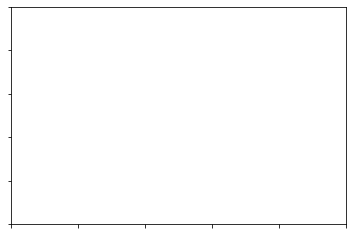

In [27]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

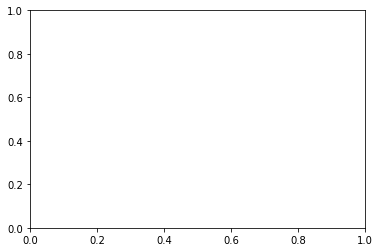

In [20]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [21]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

IndexError: Target 8 is out of bounds.

In [21]:
all_pred = []
all_probas = []
correct = 0
total = 0

model.eval()
with torch.set_grad_enabled(False):
    for batch_idx, (features, targets, levels) in enumerate(test_loader):
        
        features = features.to(DEVICE)
        logits, probas = model(features)
        all_probas.append(probas)
        predict_levels = probas > 0.5
        predicted_labels = torch.sum(predict_levels, dim=1)
        lst = [str(int(i)) for i in predicted_labels]
#         print(predicted_labels)
#         print(targets)
#         break
        for i in range(len(lst)):
            total += 1
            c = 0
            if targets[i].item() in [0, 1, 2, 3] and predicted_labels[i] <= 3:
                c = 1
            elif targets[i].item() == 4 and predicted_labels[i] == 4:
                c = 1  
            elif targets[i].item() in [5, 6, 7, 8] and predicted_labels[i] >= 5 and predicted_labels[i] <= 8:
                c = 1 
            if abs(targets[i].item() - predicted_labels[i]) <= 1:
                c = 1
            correct += c
        all_pred.extend(lst)
print(correct)
print(total)

7135
17071


In [39]:
num = 1

model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    for i, (x, y, l) in enumerate(test_loader):
        if i == num:
            logits, probas = model(x)
            predict_levels = probas > 0.5
            predicted_labels = torch.sum(predict_levels, dim=1)
            print(predicted_labels)
#             print(np.argmax(probas, axis=1))
            print(y)
            print(y[4].item() == np.argmax(probas, axis=1)[4].item())

tensor([4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 5, 4, 5, 4, 5,
        3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3])
tensor([6, 6, 4, 4, 4, 6, 1, 0, 5, 8, 1, 1, 8, 6, 0, 8, 2, 1, 2, 3, 1, 7, 4, 1,
        5, 1, 2, 7, 2, 4, 2, 1, 1, 2, 6, 6, 2, 5, 1, 5, 7, 7, 6, 2, 1, 6, 3, 7,
        4, 4, 4, 7, 2, 4, 0, 3, 0, 4, 8, 5, 3, 7, 1, 6])
False


# Conclusions (YOUR ANSWERS REQUIRED)

**1) What is your training, validation, and test accuracy (paste your numbers from above)? Also, do you notice any overfitting? If yes, why do you think your model is overfitting, and what would be a simple technique to reduce overfitting?**

- Training:  94.52%
- Validation: 89.68%
- Test 89.24%

Changes: 
- Added 3 hidden layers with 1000 units each and Relu activations
- Changed output activation function to Softmax
- Increased the learning rate to 0.1     

Yes, the model is overfitting because the training accuracy keeps improving while the validation accuracy stays the same or decreases after a certain point. This implies that the model is learning too much about the training data and hence, overfitting. A simple way to reduce overfitting would be to use L1/L2 regularization, add dropout layers or reduce the complexity/capacity of the network.

**3) Assuming you increased the accuracy by 3%, how many more correct predictions did the improved model make in the test set?**

The test dataset has 10,000 images. So, a 3% increase in accuracy means that the model made 300 more correct predictions.

10000 * 0.03 = 300 images